# Outline
Download all audio files from kaggle, label them

EDA
1. take a real audio, analyze it with graphs
2. take a fake audio, analyze it with graphs
3. learn all the different ways of analyzing an audio graph
4. Write comparisons and observations between the two

ML
1. Create a huge dataset that has all extracted features of all audio samples, labeled as real = 0, fake = 1
2. split, do cross validation on training
3. Run some models on it
4. use less features, use more features, research the features useful

Frontend
1. make an app or product
2. upload a file, have the script extract the features, then pass these extracted features into the best model, generate an overall prediction

If time permits
1. You can take this framework, scale it, and make it catered to anyone's voice, as long as there is data for real voice and data for fake voice
2. If this framework is scaled enough, it can be trained on millions of samples and be generalized

## Notes

- comparing human generated data to computer generated data.
    - understand how deepfake models generate fake voice data
    - make a catered dataset that we have control over, no bgm, mic control, make my own data and analyze it, maybe deepfake models create random noise when there is bgm or low audio quality

- find bad examples too, diverse dataset, low audio quality
    - Neural network will likely almost always perform well, if this is the case, we can explain why. If not, then cool, neural network sucks at differentiating low audio quality deepfakes etc. Explain why.

# New Notes
- margot-to-taylor
    - deepfake models seem to struggle with accents. Margot has a british accent, and when it tries to make that audio sound like taylor's voice, the accent stays. This fake audio sample also does not sound too good in general. (here, the deepfake model is given margot's audio sample, and it is told to make margot sound like taylor)
- linus-to-ryan
    - deepfake models seem to be able to work well with sparse data. In the original Ryan audio, his voice is echoey, as he is talking on stage with a mic at the golden globe awards. However, in the audio sample that linus records, it has no background audio and it is a clear stream of audio. The deepfake model is able to take that and essentially remove the echo, and isolate ryan's voice as well as his "raspiness" to impersonate linus' audio style in the linus recording. (here, the deepfake model is given linus' audio sample, and it is told to make linus sound like ryan. The deepfake model only has echoey ryan audio to work with.)

### What is an MFCC and why is it important

Mel-Frequency Cepstral Coefficients (MFCCs) are commonly used features in audio processing, especially for tasks like speech and sound classification. They are derived by first performing a Short-Time Fourier Transform (STFT), which breaks the audio signal into short frames to analyze frequency content over time. These frequencies are then mapped onto the Mel scale, a perceptual scale that reflects how humans hear pitch, emphasizing lower frequencies where our ears are more sensitive. A logarithm is applied to mimic human perception of loudness, followed by a Discrete Cosine Transform (DCT) to reduce redundancy and compress the information into a set of compact coefficients. MFCCs effectively capture the timbre and spectral shape of audio, making them valuable for distinguishing between different types of sounds, such as real versus fake audio.

### How Librosa Gets One Value (one MFCC coefficient in one frame):

1. Frame the audio

    - Slice the 1-second signal into short overlapping frames (e.g., 25 ms windows with 10 ms hop).

    - One column corresponds to one frame (about 512 samples per frame if sampling at 22,050 Hz).

2. Apply a window function

    - Multiply the frame by a window (like Hann) to reduce edge effects.

3. Take the Fourier Transform (STFT)

    - Get the power spectrum (frequency content) of the frame.

4. Map to Mel scale

    - Apply Mel filterbanks to focus on how humans hear frequency (more resolution at low frequencies).

    - Sum the energy under each Mel filter — gives a vector of Mel-band energies.

5. Take log of Mel energies

    - Humans perceive loudness on a logarithmic scale — so apply log().

6. Apply Discrete Cosine Transform (DCT)

    - Compress the information into fewer coefficients.

    - The first 20 DCT coefficients (defined in the code with n_mfcc in librosa) become your MFCC vector.

So, MFCC1 - MFCC20 are from the respective 20 DCT coefficients from the log-Mel spectrum of that frame.

### What is rolloff and why is it important

Rolloff is a feature that represents the frequency below which a specified percentage (usually 85%) of the total spectral energy is contained, which summarizes the distribution of energy across frequencies in an audio signal. It serves as a measure of audio brightness, with higher rolloff values indicating more high-frequency content. In fake vs. real audio detection, spectral rolloff is important because synthetic audio often exhibits unnatural spectral characteristics—such as inconsistent energy distribution or excessive high-frequency content—due to imperfections in generative models. Real human speech tends to produce smoother and more consistent rolloff patterns, making rolloff a useful feature for identifying artifacts and anomalies indicative of deepfakes.

Import all necessary packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import librosa
import librosa.feature
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import os
import seaborn as sns
import shap

# define torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load audio file
y, sr = librosa.load('/content/drive/My Drive/LING_199/linus-original-DEMO.mp3', sr=None)

In [ ]:
# Extract some features from a sample audio
# returns numpy arrays
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
rms = librosa.feature.rms(y=y)
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20) # use 20 coefficients

# Create time axis
time = np.linspace(0, len(y) / sr, num=len(y))

In [ ]:
print(f"Sample rate: {sr}")
print(f"Duration in seconds: {len(y) / sr}")
print(f"Max time value: {max(time)}")

Sample rate: 44100
Duration in seconds: 60.0
Max time value: 60.0


In [ ]:
# Plot waveform of amplitude over time
plt.figure(figsize=(10, 4))
plt.plot(time, y, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid()
plt.show()

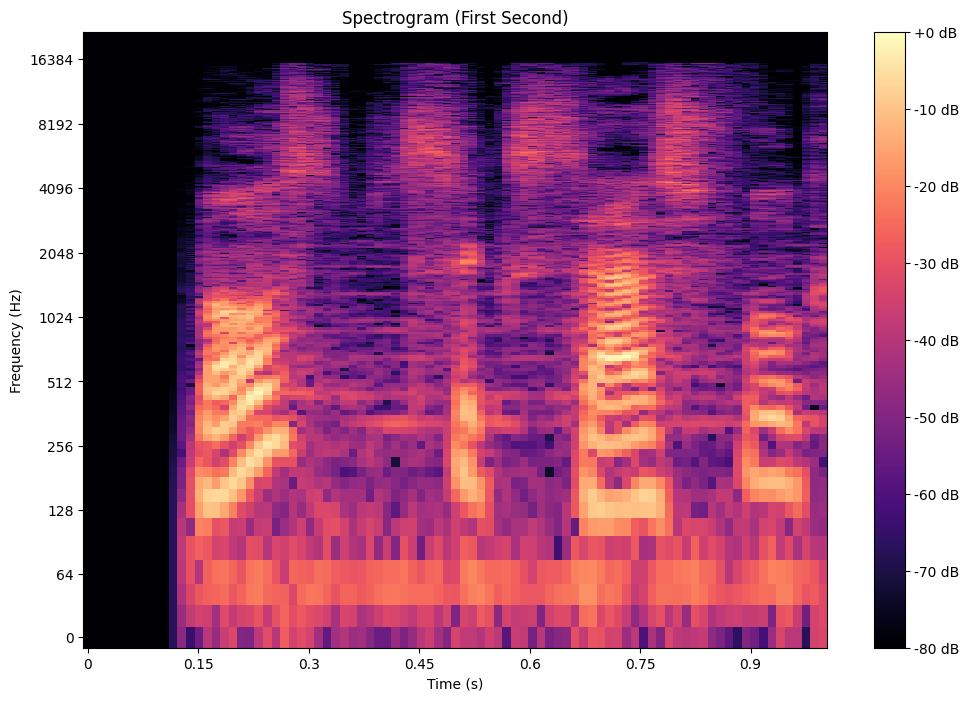

In [ ]:
# Limit to the first 10 seconds
y_1s = y[:1 * sr]  # First second of audio

# Compute the short-time Fourier transform (STFT)
D = librosa.stft(y_1s)

# Convert the amplitude to decibels (log scale)
DB = librosa.amplitude_to_db(abs(D), ref=np.max)

# Plot the spectrogram for the first 10 seconds
plt.figure(figsize=(12, 8))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (First Second)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

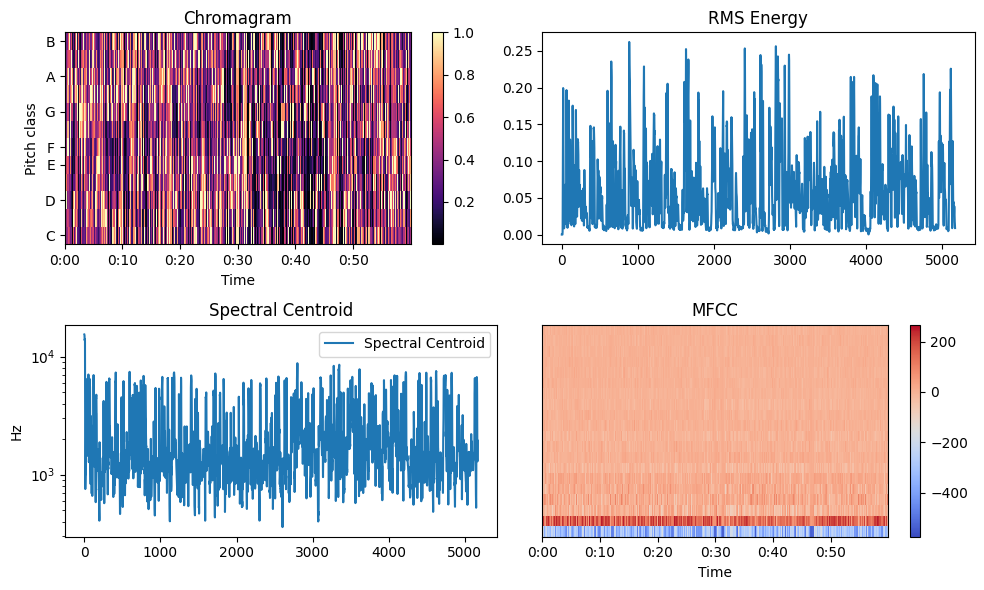

In [ ]:
plt.figure(figsize=(10, 6))

# Plot Chromagram
plt.subplot(2, 2, 1)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.title('Chromagram')

# Plot RMS
plt.subplot(2, 2, 2)
plt.plot(rms[0])
plt.title('RMS Energy')

# Plot Spectral Centroid
plt.subplot(2, 2, 3)
plt.semilogy(spectral_centroid.T, label='Spectral Centroid')
plt.ylabel('Hz')
plt.legend()
plt.title('Spectral Centroid')

# Plot MFCC
plt.subplot(2, 2, 4)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')

plt.tight_layout()
plt.show()


In [ ]:
# this dictionary defines real and fake audio samples that sound good
# in the future, the fake audio will be structured like so:
# ____-TO-MALE -> Male model training data
# ____-TO-FEMALE -> Female model training data
# this will be after I obtain fake/real male/female audio that all sound good
gender_dict = {
    'male': {
        'real': ['linus', 'musk', 'ryan'],
        'fake': ['linus-to-musk', 'taylor-to-linus', 'linus-to-ryan']
    },
    'female':
    {
        'real': ['taylor', 'margot'],
        'fake': ['taylor-to-margot', 'linus-to-taylor', 'linus-to-margot']
    }
}

real_folder_path = '/content/drive/My Drive/LING_199/REAL_audio'
fake_folder_path = '/content/drive/My Drive/LING_199/FAKE_audio'

def extract_features(real_folder_path, fake_folder_path, gender_dict, gender='both'):
    """
    Extracts audio features from real and fake audio files based on gender specification.

    Parameters:
        real_folder_path (str): path to real audio folders.
        fake_folder_path (str): path to fake audio files.
        gender_dict (dict): Dictionary defining real and fake audio file names by gender.
        gender (str): 'male', 'female', or 'both'.

    Returns:
        DataFrame: Extracted features with labels (0 for real, 1 for fake).

    Function Outline:
    1. Subset audio files based on gender
    2. Open each audio file
        a. Split audio into 1 second frames
        b. Extract features from each frame
        c. Append features to a list
    3. Convert list to dataframe
    """

    # define helper function for processing each file
    def process_file(file_path, label):
        """Loads a file, extracts features from that file, and generates a label
           given a input for label
        """
        try:
            y, sr = librosa.load(file_path, sr=None)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return []

        samples_per_second = sr
        frames = [y[i:i + samples_per_second] for i in range(0, len(y), samples_per_second)]
        features = []

        for frame in frames:
            if len(frame) < samples_per_second:
                continue
            # extract relevant features
            chromagram = librosa.feature.chroma_stft(y=frame, sr=sr).mean()
            rms = librosa.feature.rms(y=frame).mean()
            spectral_centroid = librosa.feature.spectral_centroid(y=frame, sr=sr).mean()
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=frame, sr=sr).mean()
            rolloff = librosa.feature.spectral_rolloff(y=frame, sr=sr).mean()
            zero_crossing_rate = librosa.feature.zero_crossing_rate(frame).mean()
            mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=20).mean(axis=1)

            frame_features = {
                'chroma_stft': chromagram,
                'rms': rms,
                'spectral_centroid': spectral_centroid,
                'spectral_bandwidth': spectral_bandwidth,
                'rolloff': rolloff,
                'zero_crossing_rate': zero_crossing_rate,
                **{f'mfcc{i+1}': mfcc[i] for i in range(20)},
                'LABEL': label
            }
            features.append(frame_features)

        return features

    # Select files based on gender
    if gender.lower() == 'male':
        real_files = gender_dict['male']['real']
        fake_files = gender_dict['male']['fake']
        real_path = os.path.join(real_folder_path, 'MALE')
    elif gender.lower() == 'female':
        real_files = gender_dict['female']['real']
        fake_files = gender_dict['female']['fake']
        real_path = os.path.join(real_folder_path, 'FEMALE')
    else:
        print('Must input male or female')
        return

    real_files = [f + '-original.wav' for f in real_files]
    fake_files = [f + '.wav' for f in fake_files]

    # Feature extraction

    # initiate a list of features
    # each element is a dictionary of features for one second of audio
    all_features = []

    # run process file for all real files, append features to list
    for file in real_files:
        path = os.path.join(real_path, file)
        print(f"Processing real: {path}")
        all_features.extend(process_file(path, label=0))

    # run process file for all fake files, append features to list
    for file in fake_files:
        path = os.path.join(fake_folder_path, file)
        print(f"Processing fake: {path}")
        all_features.extend(process_file(path, label=1))

    # convert list of features to dataframe, return
    return pd.DataFrame(all_features)


In [ ]:
# extract all female/male features into combined df

# real_folder_path = '/content/drive/My Drive/LING_199/REAL_audio'
# fake_folder_path = '/content/drive/My Drive/LING_199/FAKE_audio'

# commented out because it's already done
# combined_male_df = extract_features(real_folder_path, fake_folder_path, gender_dict, gender='male')
# combined_female_df = extract_features(real_folder_path, fake_folder_path, gender_dict, gender='female')
# combined_full_df = pd.concat([combined_male_df, combined_female_df])

In [3]:
# load in combined male/female csv
combined_male_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")
combined_female_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")
combined_full_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_full_df.csv")

# for each dataframe, rename 'label' to 'LABEL' if needed
if 'label' in combined_male_df.columns and 'LABEL' not in combined_male_df.columns:
    combined_male_df = combined_male_df.rename(columns={'label': 'LABEL'})
    combined_female_df = combined_female_df.rename(columns={'label': 'LABEL'})
    combined_full_df = combined_full_df.rename(columns={'label': 'LABEL'})

# Text Sentiment

In [ ]:
!pip install SpeechRecognition pydub
from pydub import AudioSegment
import speech_recognition as sr

# Convert MP3 to WAV
def convert_mp3_to_wav(mp3_file):
    audio = AudioSegment.from_mp3(mp3_file)
    wav_file = mp3_file.replace(".mp3", ".wav")
    audio.export(wav_file, format="wav")
    return wav_file

# Function to extract words from the audio file
def extract_words_from_audio(wav_file):
    # Initialize recognizer
    recognizer = sr.Recognizer()

    # Load the audio file
    with sr.AudioFile(wav_file) as source:
        # Adjust for ambient noise
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.record(source)  # Capture all the audio

    try:
        # Recognize speech using Google Web Speech API
        text = recognizer.recognize_google(audio)
        print("Recognized text:", text)

        # Split the recognized text into words
        words = text.split()
        return words

    except sr.UnknownValueError:
        print("Could not understand the audio")
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")

# Path to your MP3 file
mp3_file = '/content/drive/My Drive/LING_199/linus-original-DEMO.mp3'

# Convert MP3 to WAV
wav_file = convert_mp3_to_wav(mp3_file)

# Extract words from the converted WAV file
extract_words_from_audio(wav_file)

In [ ]:
# Sentiment analysis of words
words = extract_words_from_audio(wav_file)

# Sentiment analysis of audio

# load the full balanced ML dataset

In [ ]:
# view full balanced ml dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")
df.head()

## View the relationship between select predictor variables and the response

In [ ]:
# generate a boxplot that shows the mfcc2 for fake and real audio samples

# Assuming df is your DataFrame and it has columns 'mfcc2' and 'LABEL'
sns.boxplot(x='label', y='spectral_centroid', data=df)

In [ ]:
# generate a boxplot that shows the mfcc2 for fake and real audio samples

# Assuming df is your DataFrame and it has columns 'mfcc2' and 'LABEL'
sns.boxplot(x='label', y='spectral_bandwidth', data=df)

# Simple Neural Network

In [ ]:
# Basic NN model, 83-87.5% accuracy on balanced dataset
# 97 accuracy on male dataset

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# rename 'FAKE' as 1 and 'REAL' as 0 if necessary
if 'FAKE' in df['LABEL'].unique() and 'REAL' in df['LABEL'].unique():
    df['LABEL'] = df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# PyTorch Dataset Class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(inplace=False),
            nn.Linear(128, 64),
            nn.ReLU(inplace=False),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)


# Training parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_classes = len(np.unique(y))  # Number of unique labels

# 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = SimpleNN(input_size=X.shape[1], num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {accuracy:.4f}")

# Final evaluation on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Set Accuracy: {correct / total:.4f}")

In [ ]:
# save basic NN model that was just run
# torch.save(model, '/content/drive/My Drive/LING_199/trained_models/full_models/86.42_basic_full_model.pth')

# Simple Male Model Analysis

- A model is trained/validated on only fake/real male samples
- Diagnostics and feature importance is plotted
- Trained male model is then tested on only fake/real female samples

#### Training Parameters
- Epochs: 10
- Folds: 10
- Learning Rate: 0.01
- Batch Size: 32

In [ ]:
'''
Classification report on Basic NN male model on its own test set
'''

# Get predicted probabilities for the test set
from sklearn.metrics import classification_report

# Load the dataset
combined_male_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in combined_male_df.columns and 'LABEL' not in combined_male_df.columns:
    combined_male_df = combined_male_df.rename(columns={'label': 'LABEL'})

# rename 'FAKE' as 1 and 'REAL' as 0 if necessary
if 'FAKE' in combined_male_df['LABEL'].unique() and 'REAL' in combined_male_df['LABEL'].unique():
    combined_male_df['LABEL'] = combined_male_df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# Separate features and labels
X_male = combined_male_df.drop(columns=['LABEL']).values
y_male = combined_male_df['LABEL'].values

# Split into training and testing sets
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(
    X_male, y_male, test_size=0.2, stratify=y_male, random_state=42
)

# load 92.68 male model
male_model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/97.84_basic_male_model.pth', weights_only=False)

# Collect all test data in a single tensor
X_test_tensor_male = torch.tensor(X_test_male, dtype=torch.float32).to(device)
with torch.no_grad():
    logits = male_model(X_test_tensor_male)
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()

# Display probabilities for each class
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probabilities[:10]):
    print(f"Sample {i+1}: REAL={prob[0]:.4f}, FAKE={prob[1]:.4f}")

# Convert probabilities to predicted labels
predicted_labels = np.argmax(probabilities, axis=1)
print("\nClassification Report:")
print(classification_report(y_test_male, predicted_labels, target_names=["REAL", "FAKE"]))


Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.0037, FAKE=0.9963
Sample 2: REAL=0.9999, FAKE=0.0001
Sample 3: REAL=0.0000, FAKE=1.0000
Sample 4: REAL=0.9998, FAKE=0.0002
Sample 5: REAL=0.0000, FAKE=1.0000
Sample 6: REAL=0.9730, FAKE=0.0270
Sample 7: REAL=0.1475, FAKE=0.8525
Sample 8: REAL=0.9930, FAKE=0.0070
Sample 9: REAL=0.9420, FAKE=0.0580
Sample 10: REAL=0.0006, FAKE=0.9994

Classification Report:
              precision    recall  f1-score   support

        REAL       0.97      0.98      0.97       253
        FAKE       0.99      0.98      0.98       348

    accuracy                           0.98       601
   macro avg       0.98      0.98      0.98       601
weighted avg       0.98      0.98      0.98       601



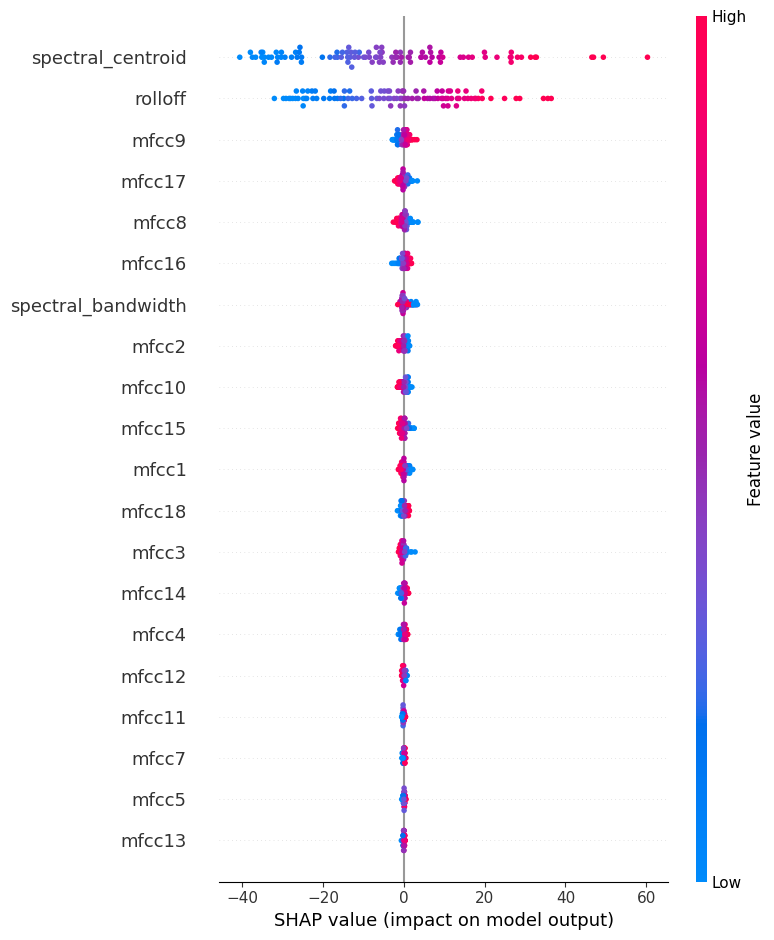

In [ ]:
# use shap to visualize feature importance in the basic NN male model
# for the male model dataset

import shap

# define the device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load basic male model
male_model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/97.84_basic_male_model.pth', weights_only=False, map_location=torch.device(device))

# Convert model to evaluation mode
male_model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train_male[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test_male[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(male_model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor_male[:100])

'''
transform shap_values shape from (100, 26, 1) to (100, 26)
where 100 is the samples of the test set
and 26 is the number of features
'''
# use this for the improved complex NN model
# shap_values = shap_values.squeeze(-1)

# use this for the basic NN model
# shap_values is (100, 26, 2), select the SHAP values for class 1
shap_values = shap_values[:, :, 1]  # Now shape is (100, 26)


# extract feature names from original dataframe
feature_names = combined_male_df.drop(columns=['LABEL']).columns.tolist()

# can also use this list manually
'''
feature_names = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
 '''

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, rng=42)

Trained Basic Male Model on Female Dataset Accuracy: 0.7412


Text(70.72222222222221, 0.5, 'True')

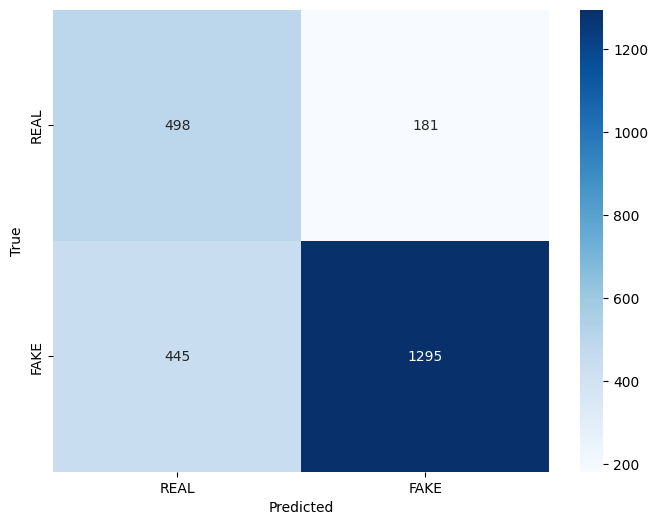

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# test the basic male model (92.68 train acc) on unseen female dataset

# load the full female data
combined_female_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# load basic male model
male_model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/97.84_basic_male_model.pth', weights_only=False, map_location=torch.device(device))

# Ensure correct column order and drop label if present
feature_names = combined_female_df.columns.drop('label').tolist()
X_new = combined_female_df[feature_names].values  # use same feature_names list from training

# define the device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor and send to device
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

# set the model to evaluation mode
male_model.eval()
with torch.no_grad():
    outputs = male_model(X_new_tensor)
    _, predictions = torch.max(outputs, 1)  # For classification

y_new = combined_female_df['label'].values
y_new_tensor = torch.tensor(y_new, dtype=torch.long).to(device)

correct = (predictions == y_new_tensor).sum().item()
accuracy = correct / len(y_new)
print(f"Trained Basic Male Model on Female Dataset Accuracy: {accuracy:.4f}")

# instead of doing just accuracy, make a confusion matrix
cm = confusion_matrix(y_new, predictions.cpu().numpy())

## format the confusion matrix and plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')

# Simple Female Model Analysis
- A model is trained/validated on only fake/real female samples
- Diagnostics and feature importance is plotted
- Trained female model is then tested on only fake/real male samples

#### Training Parameters
- Epochs: 7
- Folds: 10
- Learning Rate: 0.01
- Batch Size: 32

Notes:

- For the simple NN model, the exact same training loop and model class definition that was used for the male model above is used for the female model

- Since the female dataset is slightly smaller than the male, I used reduced epochs of 7, compared to the male model's 10.


In [ ]:
'''
Classification report on Basic NN female model on its own test set
'''

# Get predicted probabilities for the female test set
from sklearn.metrics import classification_report

# Load the full female dataset
combined_female_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in combined_female_df.columns and 'LABEL' not in combined_female_df.columns:
    combined_female_df = combined_female_df.rename(columns={'label': 'LABEL'})

# rename 'FAKE' as 1 and 'REAL' as 0 if necessary
if 'FAKE' in combined_female_df['LABEL'].unique() and 'REAL' in combined_female_df['LABEL'].unique():
    combined_female_df['LABEL'] = combined_female_df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# Separate features and labels
X_female = combined_female_df.drop(columns=['LABEL']).values
y_female = combined_female_df['LABEL'].values

# Split into training and testing sets
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(
    X_female, y_female, test_size=0.2, stratify=y, random_state=42
)

# load the trained simple NN female model (same training loop as male above)
female_model = torch.load('/content/drive/My Drive/LING_199/trained_models/female_models/96.90_basic_female_model.pth', weights_only=False)

# Collect all test data in a single tensor
X_test_tensor_female = torch.tensor(X_test_female, dtype=torch.float32).to(device)
with torch.no_grad():
    logits = female_model(X_test_tensor_female)
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()

# Display probabilities for each class
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probabilities[:10]):
    print(f"Sample {i+1}: REAL={prob[0]:.4f}, FAKE={prob[1]:.4f}")

# Convert probabilities to predicted labels
predicted_labels = np.argmax(probabilities, axis=1)
print("\nClassification Report:")
print(classification_report(y_test_female, predicted_labels, target_names=["REAL", "FAKE"], zero_division=1))

Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.0000, FAKE=1.0000
Sample 2: REAL=0.0000, FAKE=1.0000
Sample 3: REAL=0.0000, FAKE=1.0000
Sample 4: REAL=0.0000, FAKE=1.0000
Sample 5: REAL=0.0000, FAKE=1.0000
Sample 6: REAL=0.0000, FAKE=1.0000
Sample 7: REAL=0.9999, FAKE=0.0001
Sample 8: REAL=0.0000, FAKE=1.0000
Sample 9: REAL=0.0000, FAKE=1.0000
Sample 10: REAL=0.0002, FAKE=0.9998

Classification Report:
              precision    recall  f1-score   support

        REAL       0.96      0.93      0.94       136
        FAKE       0.97      0.99      0.98       348

    accuracy                           0.97       484
   macro avg       0.97      0.96      0.96       484
weighted avg       0.97      0.97      0.97       484



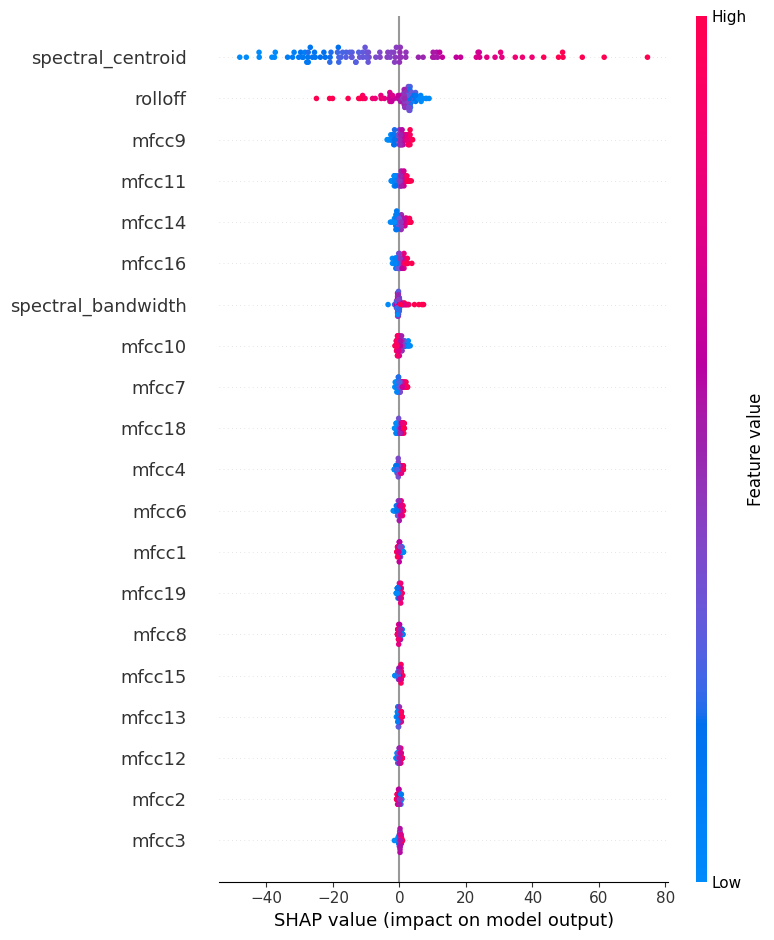

In [ ]:
# use shap to visualize feature importance in the basic NN female model
import shap

# define the device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the trained simple NN female model (same training loop as male above)
female_model = torch.load('/content/drive/My Drive/LING_199/trained_models/female_models/96.90_basic_female_model.pth', weights_only=False)

# Convert model to evaluation mode
female_model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train_female[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test_female[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(female_model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor_female[:100])

'''
transform shap_values shape from (100, 26, 1) to (100, 26)
where 100 is the samples of the test set
and 26 is the number of features
'''
# use this for the improved complex NN model
# shap_values = shap_values.squeeze(-1)

# use this for the basic NN model
# shap_values is (100, 26, 2), select the SHAP values for class 1
shap_values = shap_values[:, :, 1]  # Now shape is (100, 26)


# extract feature names from original dataframe
feature_names = combined_female_df.drop(columns=['LABEL']).columns.tolist()

# can also use this list manually
'''
feature_names = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
 '''

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, rng=42)

Trained Basic Female Model on Male Dataset Accuracy: 0.5904


Text(70.72222222222221, 0.5, 'True')

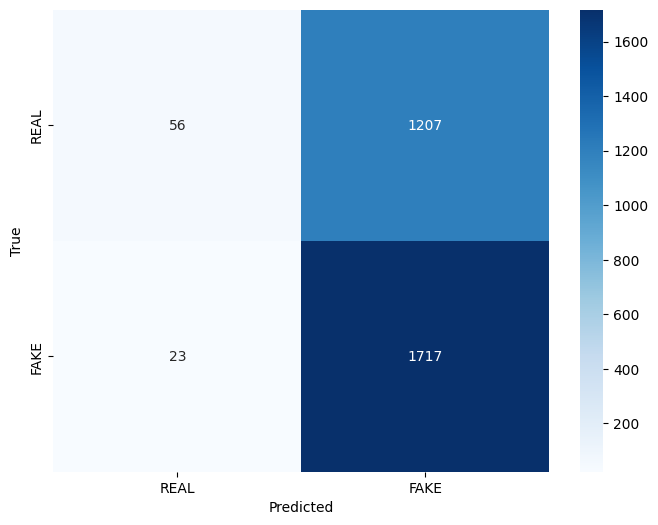

In [ ]:
# test the basic female model on unseen male dataset

# load the full male data
combined_male_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")

# load the trained simple NN female model (same training loop as male above)
female_model = torch.load('/content/drive/My Drive/LING_199/trained_models/female_models/94.42_basic_female_model.pth', weights_only=False)

# Ensure correct column order and drop label if present
feature_names = combined_male_df.columns.drop('label').tolist()
X_new = combined_male_df[feature_names].values  # use same feature_names list from training

# define the device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensor and send to device
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

# set the model to evaluation mode
female_model.eval()
with torch.no_grad():
    outputs = female_model(X_new_tensor)
    _, predictions = torch.max(outputs, 1)  # For classification

# Use the labels from the male dataframe (the new data)
y_new = combined_male_df['label'].values
y_new_tensor = torch.tensor(y_new, dtype=torch.long).to(device)

correct = (predictions == y_new_tensor).sum().item()
accuracy = correct / len(y_new)
print(f"Trained Basic Female Model on Male Dataset Accuracy: {accuracy:.4f}")

# instead of doing just accuracy, make a confusion matrix
cm = confusion_matrix(y_new, predictions.cpu().numpy())

## format the confusion matrix and plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')

# Simple Full Model Analysis

Simple Neural Network trained on full balanced dataset

#### Training Parameters
- Epochs: 10
- Folds: 10
- Learning Rate: 0.01
- Batch Size: 32

In [ ]:
'''
Classification report on Basic full model on its own test set
'''

# Get predicted probabilities for the female test set
from sklearn.metrics import classification_report

# Load the full female dataset
balanced_df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in balanced_df.columns and 'LABEL' not in balanced_df.columns:
    balanced_df = balanced_df.rename(columns={'label': 'LABEL'})

# rename 'FAKE' as 1 and 'REAL' as 0 if necessary
if 'FAKE' in balanced_df['LABEL'].unique() and 'REAL' in balanced_df['LABEL'].unique():
    balanced_df['LABEL'] = balanced_df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# Separate features and labels
X_full = balanced_df.drop(columns=['LABEL']).values
y_full = balanced_df['LABEL'].values

# Split into training and testing sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# load the trained simple NN female model (same training loop as male/female above)
full_model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/86.42_basic_full_model.pth', weights_only=False)

# Collect all test data in a single tensor
X_test_tensor_full= torch.tensor(X_test_full, dtype=torch.float32).to(device)
with torch.no_grad():
    logits = full_model(X_test_tensor_full)
    probabilities = torch.softmax(logits, dim=1).cpu().numpy()

# Display probabilities for each class
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probabilities[:10]):
    print(f"Sample {i+1}: REAL={prob[0]:.4f}, FAKE={prob[1]:.4f}")

# Convert probabilities to predicted labels
predicted_labels = np.argmax(probabilities, axis=1)
print("\nClassification Report:")
print(classification_report(y_test_full, predicted_labels, target_names=["REAL", "FAKE"], zero_division=1))

Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.0016, FAKE=0.9984
Sample 2: REAL=0.0040, FAKE=0.9960
Sample 3: REAL=0.9961, FAKE=0.0039
Sample 4: REAL=1.0000, FAKE=0.0000
Sample 5: REAL=0.0014, FAKE=0.9986
Sample 6: REAL=0.1502, FAKE=0.8498
Sample 7: REAL=0.1350, FAKE=0.8650
Sample 8: REAL=0.2039, FAKE=0.7961
Sample 9: REAL=0.0718, FAKE=0.9282
Sample 10: REAL=0.9925, FAKE=0.0075

Classification Report:
              precision    recall  f1-score   support

        REAL       0.88      0.84      0.86      1178
        FAKE       0.85      0.89      0.87      1178

    accuracy                           0.86      2356
   macro avg       0.87      0.86      0.86      2356
weighted avg       0.87      0.86      0.86      2356



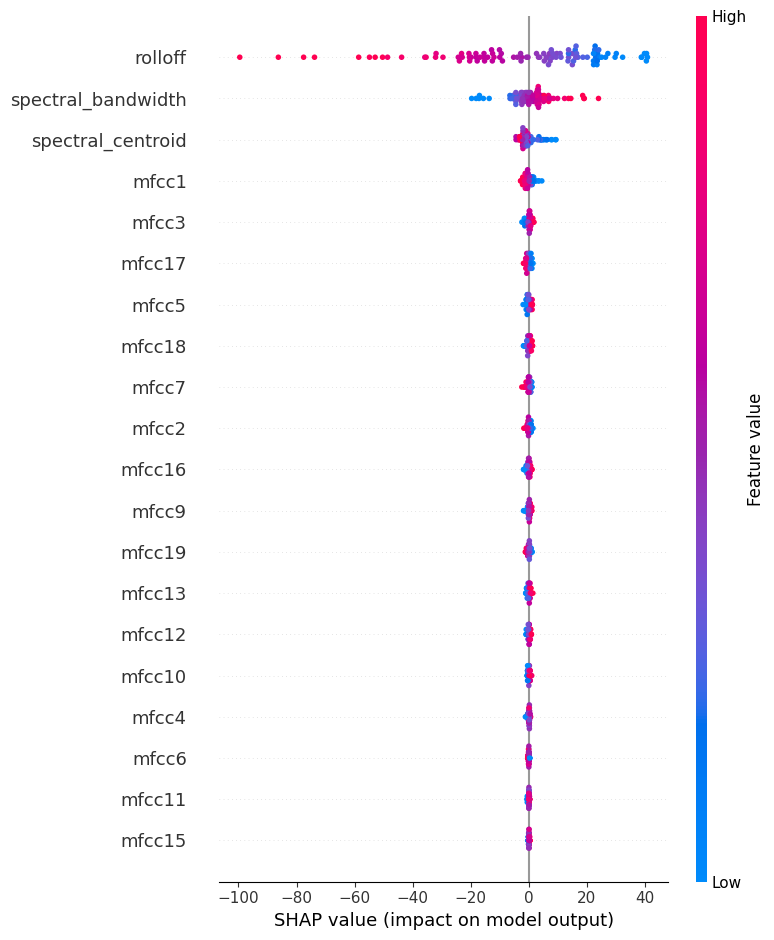

In [ ]:
# use shap to visualize feature importance in the basic NN full model
import shap

# define the device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the trained simple NN female model (same training loop as male/female above)
full_model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/86.42_basic_full_model.pth', weights_only=False)

# Convert model to evaluation mode
full_model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train_full[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test_full[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(full_model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor_full[:100])

'''
transform shap_values shape from (100, 26, 1) to (100, 26)
where 100 is the samples of the test set
and 26 is the number of features
'''
# use this for the improved complex NN model
# shap_values = shap_values.squeeze(-1)

# use this for the basic NN model
# shap_values is (100, 26, 2), select the SHAP values for class 1
shap_values = shap_values[:, :, 1]  # Now shape is (100, 26)


# extract feature names from original dataframe
feature_names = balanced_df.drop(columns=['LABEL']).columns.tolist()

# can also use this list manually
'''
feature_names = ['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13',
 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
 '''

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test_full[:100], feature_names=feature_names, rng=42)

Full Model Accuracy on Balanced Dataset: 0.8737


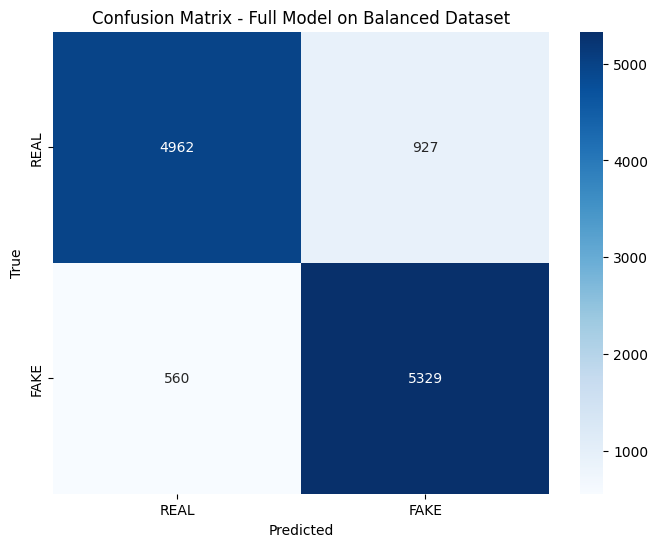

In [ ]:
# confusion matrix for simple NN on full dataset

# Load the full balanced dataset
balanced_df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")

# Load the full model (make sure weights_only=False is supported)
full_model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/86.42_basic_full_model.pth', weights_only=False)

# Ensure correct column order and drop label
feature_names = balanced_df.columns.drop('LABEL').tolist()
X_full = balanced_df[feature_names].values
y_full = balanced_df['LABEL'].values

# Map string labels to numeric
label_mapping = {'REAL': 0, 'FAKE': 1}
y_full = balanced_df['LABEL'].map(label_mapping).values

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensors
X_tensor = torch.tensor(X_full, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_full, dtype=torch.long).to(device)

# Move model to device
full_model.to(device)
full_model.eval()

# Get predictions
with torch.no_grad():
    outputs = full_model(X_tensor)
    _, predictions = torch.max(outputs, 1)

# Calculate accuracy
correct = (predictions == y_tensor).sum().item()
accuracy = correct / len(y_full)
print(f"Full Model Accuracy on Balanced Dataset: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_full, predictions.cpu().numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Full Model on Balanced Dataset')
plt.show()

# Complex Neural Network Model

In [ ]:
# Complex NN model, unused ATM
class ComplexNN(nn.Module):
    def __init__(self, input_size):
        super(ComplexNN, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        return self.sigmoid(x)

# Improved Complex Neural Network Model

In [26]:
# Improved Complex NN model, 98.26% accuracy on full balanced dataset
# 83% accuracy for the male dataset

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Convert LABEL column: 'REAL' -> 0, 'FAKE' -> 1 if necessary
if 'FAKE' in df['LABEL'].unique() and 'REAL' in df['LABEL'].unique():
    df['LABEL'] = df['LABEL'].map({'FAKE': 1, 'REAL': 0})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure shape compatibility

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ImprovedComplexNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedComplexNN, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)  # Added BatchNorm
        self.act4 = Swish()  # Swish activation function

        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.act4(x)

        x = self.fc5(x)
        return torch.sigmoid(x)  # Apply Sigmoid at the output layer

# Training parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold + 1}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize the ImprovedComplexNN model
    model = ImprovedComplexNN(input_size=X.shape[1]).to(device)
    criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop

        # set the model to evaluation mode
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}: Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {accuracy:.4f}")

# Final evaluation on the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {correct / total:.4f}")

Fold 1
Epoch 1: Train Loss: 0.5143, Val Loss: 0.3537, Val Acc: 0.8763
Epoch 2: Train Loss: 0.3288, Val Loss: 0.1961, Val Acc: 0.9742
Epoch 3: Train Loss: 0.2216, Val Loss: 0.0967, Val Acc: 0.9897
Epoch 4: Train Loss: 0.1592, Val Loss: 0.0861, Val Acc: 0.9897
Epoch 5: Train Loss: 0.1289, Val Loss: 0.0562, Val Acc: 0.9897
Epoch 6: Train Loss: 0.1002, Val Loss: 0.0770, Val Acc: 0.9794
Epoch 7: Train Loss: 0.0966, Val Loss: 0.1070, Val Acc: 0.9536
Epoch 8: Train Loss: 0.1254, Val Loss: 0.8287, Val Acc: 0.7320
Epoch 9: Train Loss: 0.0979, Val Loss: 0.0418, Val Acc: 0.9897
Epoch 10: Train Loss: 0.1044, Val Loss: 0.1072, Val Acc: 0.9588
Fold 2
Epoch 1: Train Loss: 0.4793, Val Loss: 0.5222, Val Acc: 0.7990
Epoch 2: Train Loss: 0.2979, Val Loss: 0.2213, Val Acc: 0.9381
Epoch 3: Train Loss: 0.1966, Val Loss: 0.2060, Val Acc: 0.9485
Epoch 4: Train Loss: 0.1698, Val Loss: 0.4232, Val Acc: 0.7784
Epoch 5: Train Loss: 0.1399, Val Loss: 0.0737, Val Acc: 0.9691
Epoch 6: Train Loss: 0.1200, Val Loss: 0

In [28]:
# save the model that was just trained

# torch.save(model, '/content/drive/My Drive/LING_199/trained_models/female_models/97.93_complex_female_model.pth')

# Complex Model on Male Dataset Analysis

Complex model will be trained only on male data, and then tested on the female data

#### Training Parameters
- Epochs: 10
- Folds: 10
- Learning Rate: 0.01
- Batch Size: 32

In [27]:
'''Classification report on Complex Male model's own test dataset
'''

# print predicted probabilities of each sample, and classification report
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")

# rename columns in df to 'label' from 'LABEL' if needed
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Map string labels to numeric for BOTH y_test and predicted_labels
label_mapping = {'REAL': 0, 'FAKE': 1}

# load a previously trained model, make sure weights only is false
complex_male_model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/95.51_complex_male_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = complex_male_model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Display probabilities for each test sample (first 10 rows)
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probs[:10]):
    print(f"Sample {i+1}: REAL={1 - prob:.4f}, FAKE={prob:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=["REAL", "FAKE"]))

Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.0111, FAKE=0.9889
Sample 2: REAL=0.9995, FAKE=0.0005
Sample 3: REAL=0.0105, FAKE=0.9895
Sample 4: REAL=0.9985, FAKE=0.0015
Sample 5: REAL=0.0157, FAKE=0.9843
Sample 6: REAL=0.9987, FAKE=0.0013
Sample 7: REAL=0.0335, FAKE=0.9665
Sample 8: REAL=0.9142, FAKE=0.0858
Sample 9: REAL=0.6592, FAKE=0.3408
Sample 10: REAL=0.0109, FAKE=0.9891

Classification Report:
              precision    recall  f1-score   support

        REAL       1.00      0.89      0.94       253
        FAKE       0.93      1.00      0.96       348

    accuracy                           0.96       601
   macro avg       0.96      0.95      0.95       601
weighted avg       0.96      0.96      0.95       601



<ipython-input-11-025e7d19753c>:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


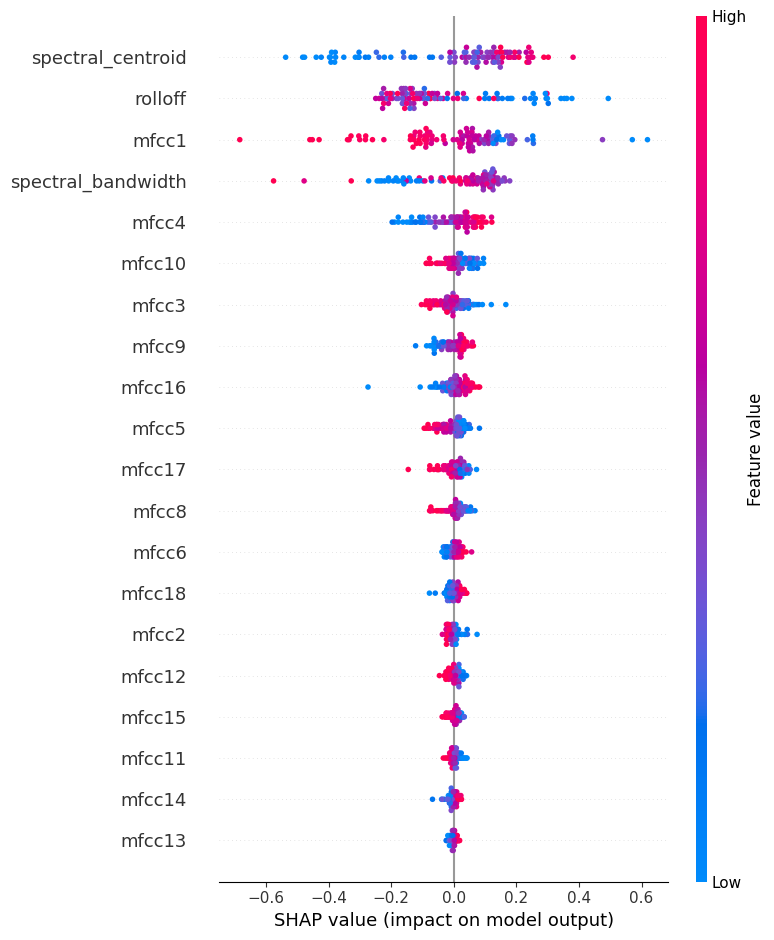

In [11]:
'''SHAP explainer for complex male model
'''

# Convert model to evaluation mode
complex_male_model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(complex_male_model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor[:100])

# use this for the improved complex NN model
shap_values = shap_values.squeeze(-1)

# use this for the basic NN model
# shap_values is (100, 26, 2), select the SHAP values for class 1
# shap_values = shap_values[:, :, 1]  # Now shape is (100, 26)

# extract feature names from original dataframe
feature_names = df.drop(columns=['LABEL']).columns.tolist()

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)

Accuracy: 0.7045


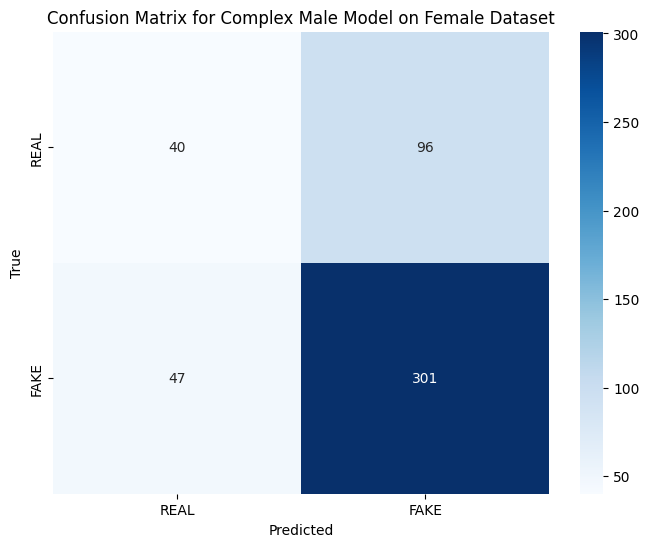

In [25]:
"""
Testing the complex male model on the female dataset
"""

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# define device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load a previously trained model, make sure weights only is false
model = torch.load('/content/drive/My Drive/LING_199/trained_models/male_models/95.51_complex_male_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# print accuracy
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(f"Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Complex Male Model on Female Dataset')
plt.show()

# Complex Model on Female Dataset Analysis

Complex model will be trained only on the female data, and then tested on the male data

#### Training Parameters
- Epochs: 10
- Folds: 10
- Learning Rate: 0.01
- Batch Size: 32

In [36]:
'''Classification report on Complex Female model's own test dataset
'''

# print predicted probabilities of each sample, and classification report

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# rename columns in df to 'label' from 'LABEL' if needed
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# load a previously trained model, make sure weights only is false
complex_female_model = torch.load('/content/drive/My Drive/LING_199/trained_models/female_models/97.93_complex_female_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = complex_female_model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Display probabilities for each test sample (first 10 rows)
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probs[:10]):
    print(f"Sample {i+1}: REAL={1 - prob:.4f}, FAKE={prob:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=["REAL", "FAKE"]))

Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.0080, FAKE=0.9920
Sample 2: REAL=0.0041, FAKE=0.9959
Sample 3: REAL=0.0025, FAKE=0.9975
Sample 4: REAL=0.0043, FAKE=0.9957
Sample 5: REAL=0.0066, FAKE=0.9934
Sample 6: REAL=0.0032, FAKE=0.9968
Sample 7: REAL=0.8543, FAKE=0.1457
Sample 8: REAL=0.0022, FAKE=0.9978
Sample 9: REAL=0.0032, FAKE=0.9968
Sample 10: REAL=0.0048, FAKE=0.9952

Classification Report:
              precision    recall  f1-score   support

        REAL       0.99      0.93      0.96       136
        FAKE       0.97      1.00      0.99       348

    accuracy                           0.98       484
   macro avg       0.98      0.97      0.97       484
weighted avg       0.98      0.98      0.98       484



<ipython-input-32-141c064bc47a>:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


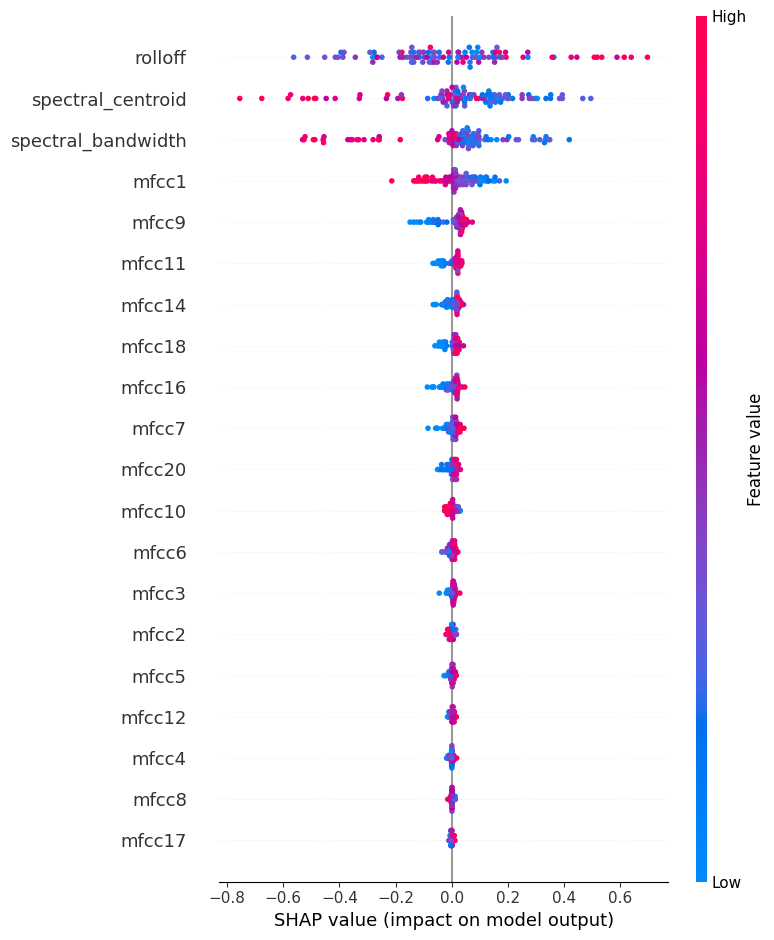

In [32]:
'''SHAP explainer for complex female model
'''

# Convert model to evaluation mode
complex_female_model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(complex_female_model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor[:100])

# use this for the improved complex NN model
shap_values = shap_values.squeeze(-1)

# use this for the basic NN model
# shap_values is (100, 26, 2), select the SHAP values for class 1
# shap_values = shap_values[:, :, 1]  # Now shape is (100, 26)

# extract feature names from original dataframe
feature_names = df.drop(columns=['LABEL']).columns.tolist()

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)

Accuracy: 0.7887


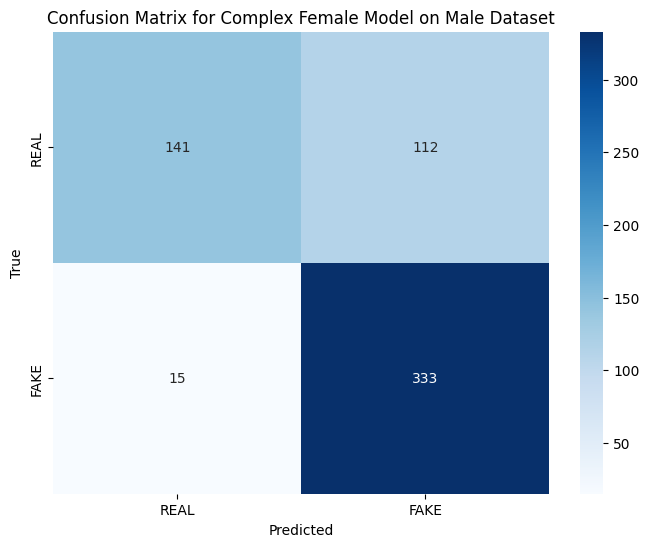

In [33]:
"""
Testing the complex female model on the male dataset
"""

# Load the male dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")

# rename 'label' to 'LABEL' if necessary
if 'label' in df.columns and 'LABEL' not in df.columns:
    df = df.rename(columns={'label': 'LABEL'})

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# define device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load a previously trained model, make sure weights only is false
complex_female_model = torch.load('/content/drive/My Drive/LING_199/trained_models/female_models/97.93_complex_female_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = complex_female_model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# print accuracy
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
print(f"Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Complex Female Model on Male Dataset')
plt.show()

# Complex Model on Full Dataset

#### Training Parameters
- Epochs: 10
- Folds: 10
- Learning Rate: 0.01
- Batch Size: 32

In [34]:
'''Classification report on Complex model's own test dataset
'''

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Map string labels to numeric for BOTH y_test and predicted_labels
label_mapping = {'REAL': 0, 'FAKE': 1}
y_test = [label_mapping[label] for label in y_test] # Convert y_test to numerical labels

# define device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load a previously trained model, make sure weights only is false
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Display probabilities for each test sample (first 10 rows)
print("Example predicted probabilities for test set (first 10 rows):")
for i, prob in enumerate(probs[:10]):
    print(f"Sample {i+1}: REAL={1 - prob:.4f}, FAKE={prob:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels, target_names=["REAL", "FAKE"]))

Example predicted probabilities for test set (first 10 rows):
Sample 1: REAL=0.9947, FAKE=0.0053
Sample 2: REAL=0.9997, FAKE=0.0003
Sample 3: REAL=0.0105, FAKE=0.9895
Sample 4: REAL=0.0483, FAKE=0.9517
Sample 5: REAL=0.9474, FAKE=0.0526
Sample 6: REAL=0.9901, FAKE=0.0099
Sample 7: REAL=0.9964, FAKE=0.0036
Sample 8: REAL=0.9835, FAKE=0.0165
Sample 9: REAL=0.9813, FAKE=0.0187
Sample 10: REAL=0.0425, FAKE=0.9575

Classification Report:
              precision    recall  f1-score   support

        REAL       0.97      0.98      0.98      1178
        FAKE       0.98      0.97      0.98      1178

    accuracy                           0.98      2356
   macro avg       0.98      0.98      0.98      2356
weighted avg       0.98      0.98      0.98      2356



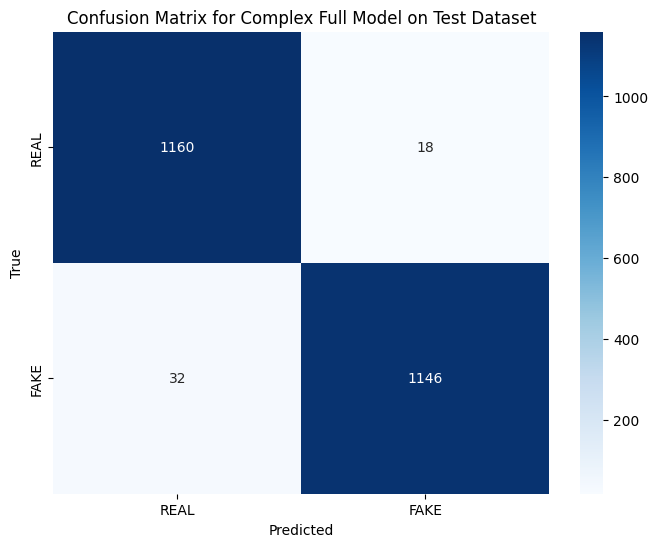

In [37]:
'''Confusion matrix of complex model on it's own test data
'''
# create a confusion matrix of complex model on full dataset's test data

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/DATASET-balanced.csv")

# Separate features and labels
X = df.drop(columns=['LABEL']).values
y = df['LABEL'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Map string labels to numeric for BOTH y_test and predicted_labels
label_mapping = {'REAL': 0, 'FAKE': 1}
y_test = [label_mapping[label] for label in y_test] # Convert y_test to numerical labels

# define device, cuda if available, cpu otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load a previously trained model, make sure weights only is false
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False, map_location=torch.device(device))

# Collect all test data in a single tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predicted probabilities
with torch.no_grad():
    probs = model(X_test_tensor).cpu().numpy().flatten()  # Shape: (N,)
    predicted_labels = (probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Complex Full Model on Test Dataset')
plt.show()

<ipython-input-21-1057ecb73883>:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


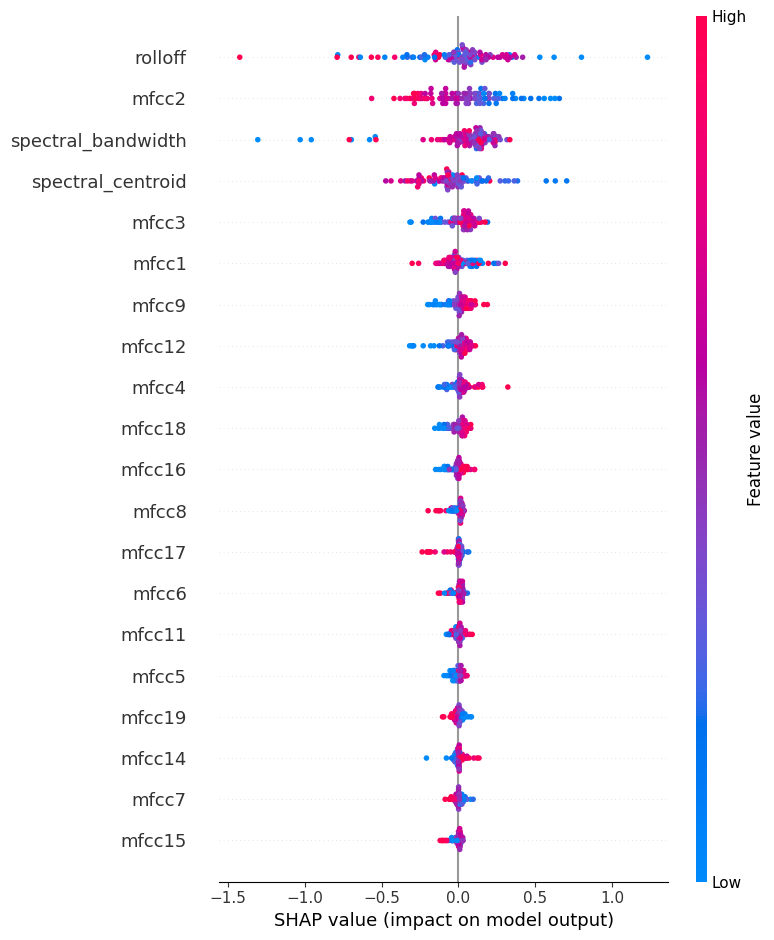

In [ ]:
# use shap to visualize feature importance in the improved Complex NN model
# for the full balanced ML dataset.
# First, we take the trained model, and a small batch of training data for
# shap to compute the baseline model behavior
# Then, we define the shap explainer, and get shap values by running
# the explainer (shap's base model behavior from the small batch of train data)
# on a subset of testing samples from the test data
# Now, each feature has ranked importance, with a shap value that shows how
# important the value is for determining the class for a test sample

import shap

# Convert model to evaluation mode
model.eval()

# prepare data for shap

# background is a small batch of training samples used to approximate
# the expected model output in SHAP. This is used to calculate baseline
# contributions
background = torch.tensor(X_train[:100], dtype=torch.float32).to(device)

# subset the first 100 test samples for feature explanation
X_test_tensor = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Create a SHAP GradientExplainer, for PyTorch neural networks
# this explainer uses the background data to calculate baseline model behavior
explainer = shap.GradientExplainer(model, background)

# Get SHAP values for a subset of the test set
# shape: (samples, features, outputs) outputs = 1 for binary classification
shap_values = explainer.shap_values(X_test_tensor[:100])

# transform shap_values shape from (100, 26, 1) to (100, 26)
# where 100 is the samples of the test set
# and 26 is the number of features
shap_values = shap_values.squeeze(-1)

# extract feature names from original dataframe
feature_names = df.drop(columns=['LABEL']).columns.tolist()

# Sometimes, for binary classification with a single output,
# shap_values is a list with one element depending on the backend
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Shape: (samples, features)

# Convert to numpy if needed
if torch.is_tensor(shap_values):
    shap_values = shap_values.cpu().numpy()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)


### Interpretation of shap plot
- y-axis has the feature names present in each audio sample
- x-axis is the shap value, which is the impact on model output.
    - positive shap values push the prediction towards the positive class, in this case FAKE (1)
    - negative shap values push the prediction towards the negative class, in this case REAL (0)
- Color (Red = High, Blue = Low)
    - shows whether high or low feature values are associated with pushing predictions towards FAKE or REAL

For instance, we see that MFCC2 is high ranked (important) in explaining the difference between fake and real audio samples, and that as the MFCC2 value goes up (High red color), the class goes to REAL (negative shap value), but as it goes down (Blue low color), the class goes to FAKE (positive shap value).

The higher the MFCC2 value is, the more real the audio sample is, and the lower the MFCC2 value is, the more fake the audio sample is.

# EDA on predictors after analysis of trained models

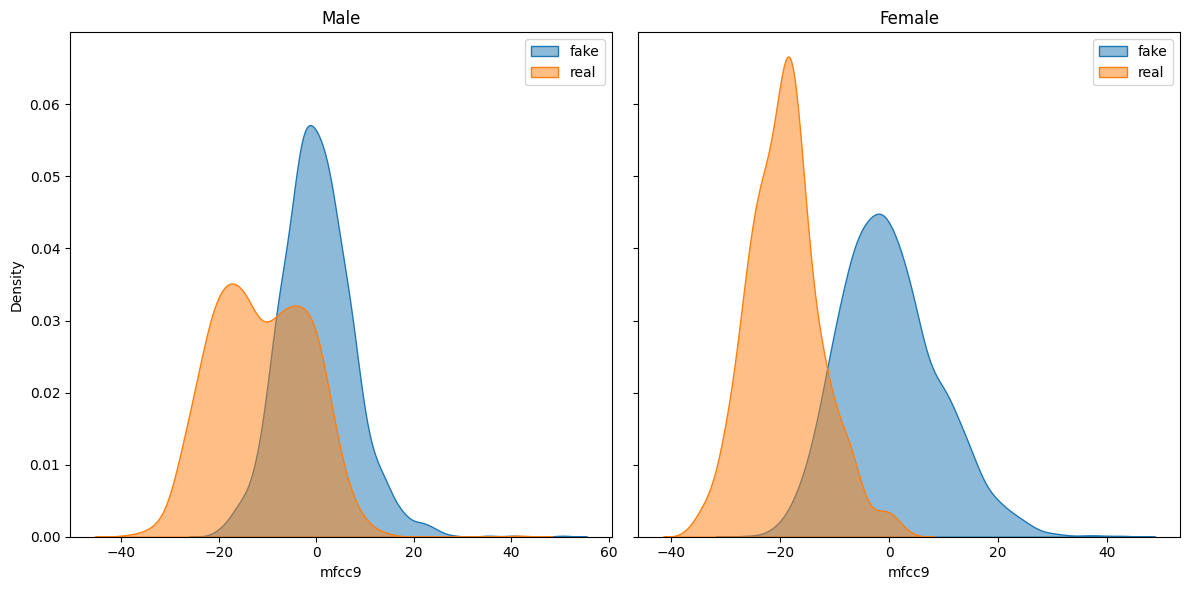

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature = 'mfcc9'

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Male density plot
sns.kdeplot(
    data=combined_male_df[combined_male_df['LABEL'] == 1],
    x=feature,
    label='fake',
    fill=True,
    alpha=0.5,
    ax=axes[0]
)
sns.kdeplot(
    data=combined_male_df[combined_male_df['LABEL'] == 0],
    x=feature,
    label='real',
    fill=True,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title('Male')
axes[0].set_xlabel(feature)
axes[0].set_ylabel('Density')
axes[0].legend()

# Female density plot
sns.kdeplot(
    data=combined_female_df[combined_female_df['LABEL'] == 1],
    x=feature,
    label='fake',
    fill=True,
    alpha=0.5,
    ax=axes[1]
)
sns.kdeplot(
    data=combined_female_df[combined_female_df['LABEL'] == 0],
    x=feature,
    label='real',
    fill=True,
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('Female')
axes[1].set_xlabel(feature)
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()


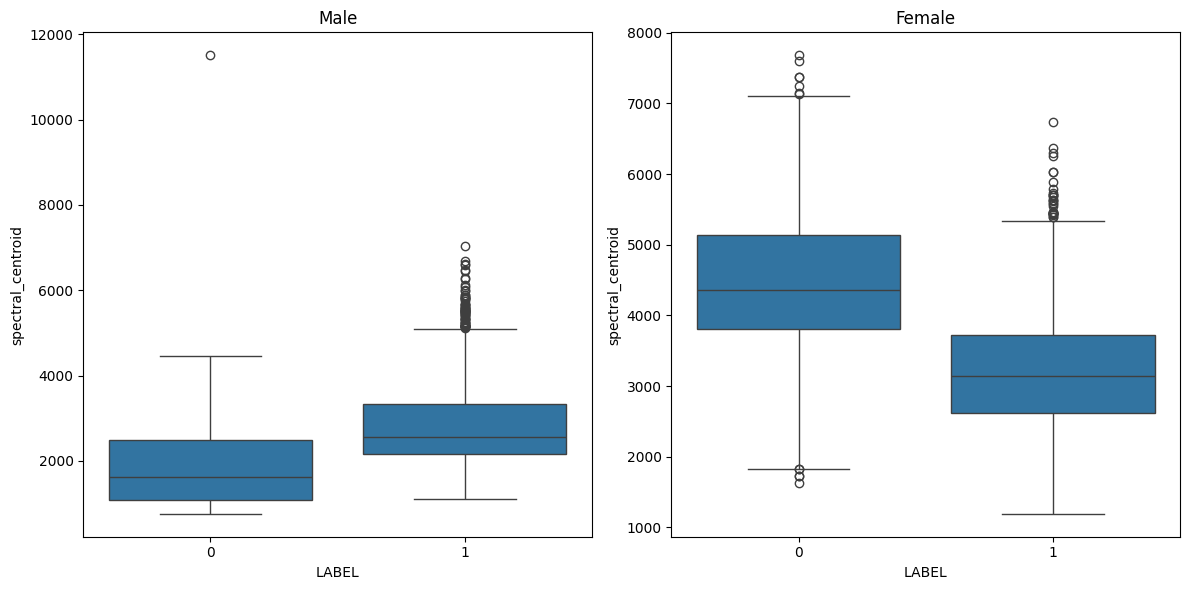

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first boxplot on the first subplot (axes[0])
sns.boxplot(x='LABEL', y='spectral_centroid', data=combined_male_df, ax=axes[0])
axes[0].set_title('Male')  # Set title for the first subplot

# Plot the second boxplot on the second subplot (axes[1])
sns.boxplot(x='LABEL', y='spectral_centroid', data=combined_female_df, ax=axes[1])
axes[1].set_title('Female')  # Set title for the second subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Findings, Interpretations, Next Steps

- Interpret shap plots for each model (male/female)
- do EDA on real/fake male/female audio, and potentially explain why the model misclassifies
    - For example, we see that in the male model, when rolloff is low, the model thinks that the sample is real. However, we see that lower values of rolloff in the female data indicate a fake sample. This is why the male model misclassifies Fake female samples as Real. Similarly, the female model misclassifies Real samples as fake.
        - The male model sees a low rolloff value, and says that it is a real sample, but a low rolloff value is fake in female samples, and vice versa. The SHAP values for rolloff agree with EDA observations in the male and female dataset
    - Neural Networks use complex, nonlinear combinations of features to make classification decisions. We see that spectral centroid, the most important feature both the male and female models in SHAP shows that lower values equate to real samples. However, upon doing EDA on the actual datasets, we see that lower values for male equate to real samples, but lower values for female equate to fake samples. This happens because SHAP reflects how the model uses spectral centroid in combination with other features, not its isolated correlation with the label. Even if low spectral centroid alone is associated with fake samples in the female dataset, the model may have learned that low values—when paired with certain patterns in other features—indicate real samples, leading SHAP to attribute a positive contribution toward the "real" class.
        - The female model likely found some complex combination of all the features that can explain fake and real samples. Thus, the female model is overfit to the female samples, and similarly, the male model is overfit to the male samples. However, the male model better generalizes to female data potentially due to more real samples. (look into balancing)
- Balancing of each dataset, get more data

## Todos
- Importance of predictors may be different based on who is speaking, and how they are conducting themselves
    - female/male pitch, can mfccs or other features capture cadence?

- male/female models (these models are only trained on fake/real male/female data)
    - look at samples, only use fake samples that sound super real to me
    - fake samples that sound real list
        - male
            - taylor-to-linus
            - linus-to-musk
            - linus-to-ryan
        - female
            - taylor-to-margot
            - linus-to-taylor
            - linus-to-margot
    - train/validate the male model on real and fake linus/musk/ryan audio
        - test this model on real/fake taylor/margot audio

--

- Compare the SHAPs of basic gendered models to complex gendered models

- look into mfccs

- Balanced dataset:
    - use all the real audio if it is part of the fake audio that sound good
    - use all fake audio that sounds good to me
    - balance by usign ranndom sampling, and undersample the fake class

- Use an extreme gradient boosting model

# Extreme Gradient Boosting Model

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# load balanced dataset
df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# rename 'label' to 'LABEL' if needed
if 'label' in df.columns and 'LABEL' not in df.columns:
    df.rename(columns={'label': 'LABEL'}, inplace=True)

# convert all 'REAL' to 0 and 'FAKE' to 1 in the 'LABEL' column if REAL and FAKE are in the 'LABEL' column
if 'REAL' in df['LABEL'].values and 'FAKE' in df['LABEL'].values:
    df['LABEL'] = df['LABEL'].replace({'REAL': 0, 'FAKE': 1})

# 1. Prepare the data
X = df.drop('LABEL', axis=1)  # Features (all columns except 'LABEL')
y = df['LABEL']               # Target variable

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% for testing
    random_state=42,
    stratify=y        # Maintain class distribution
)

# Create DMatrix for XGBoost (optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',       # Logarithmic loss
    'eta': 0.1,                     # Learning rate
    'max_depth': 6,                 # Maximum tree depth
    'subsample': 0.8,               # Subsample ratio
    'colsample_bytree': 0.8,        # Feature subsample ratio
    'seed': 42,
    'early_stopping_rounds': 10
}

# Train the model
num_rounds = 100
eval_list = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=eval_list,
    verbose_eval=10
)

[0]	train-logloss:0.51263	eval-logloss:0.51339
[10]	train-logloss:0.17357	eval-logloss:0.19029


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-logloss:0.07346	eval-logloss:0.09714
[30]	train-logloss:0.03615	eval-logloss:0.06218
[40]	train-logloss:0.02061	eval-logloss:0.04707
[50]	train-logloss:0.01306	eval-logloss:0.03927
[60]	train-logloss:0.00946	eval-logloss:0.03618
[70]	train-logloss:0.00749	eval-logloss:0.03433
[80]	train-logloss:0.00601	eval-logloss:0.03264
[90]	train-logloss:0.00512	eval-logloss:0.03240
[99]	train-logloss:0.00451	eval-logloss:0.03114


In [63]:
# save the model that was just run
# model.save_model('/content/drive/My Drive/LING_199/trained_models/female_models/99.38_xgb_female_model.json')

# Extreme Gradient Boosting Full Model Analysis

In [45]:
'''Classification report for Extreme Gradient Boosting Full Model
'''

# load a previously trained model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/full_models/98.90_xgb_full_model.json')

# Make predictions
y_pred_proba = model.predict(dtest)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Class predictions

# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9890

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1178
           1       0.99      0.99      0.99      1178

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



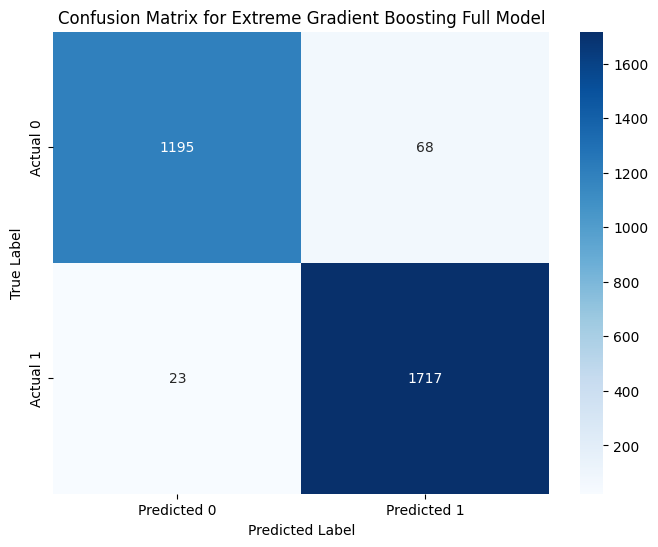

In [72]:
'''Plot confusion matrix for Extreme Gradient Boosting Full Model
'''
# load a previously trained model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/full_models/98.90_xgb_full_model.json')

# Make predictions
y_pred_proba = model.predict(dtest)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Class predictions

# seaborn confusion matrix helper
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])

# plot
plot_confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix for Extreme Gradient Boosting Full Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

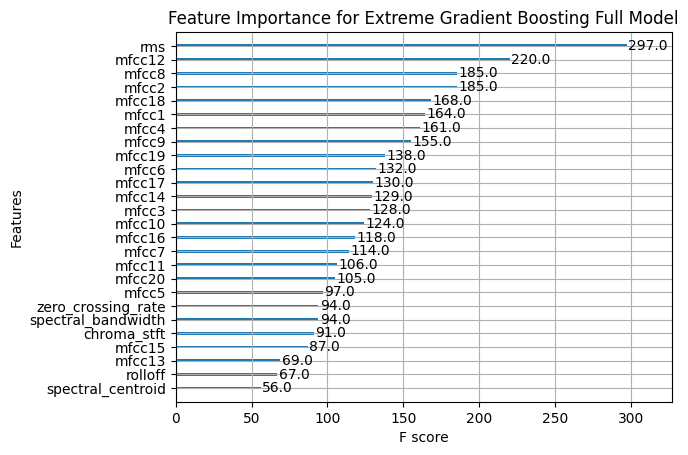

In [49]:
'''Feature Importance plot for full Extreme Gradient Boosting Model
'''

# load a previously trained model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/full_models/98.90_xgb_full_model.json')

# Feature importance plot
xgb.plot_importance(model)
plt.title('Feature Importance for Extreme Gradient Boosting Full Model')
plt.show()

# Extreme Gradient Boosting Male Model Analysis

In [57]:
'''Classification report on XGB male model's own test data
'''

# load a xgb male model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/male_models/99.17_xgb_male_model.json')

# Make predictions
y_pred_proba = model.predict(dtest)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Class predictions

# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9917

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       253
           1       0.99      0.99      0.99       348

    accuracy                           0.99       601
   macro avg       0.99      0.99      0.99       601
weighted avg       0.99      0.99      0.99       601



Accuracy: 0.73


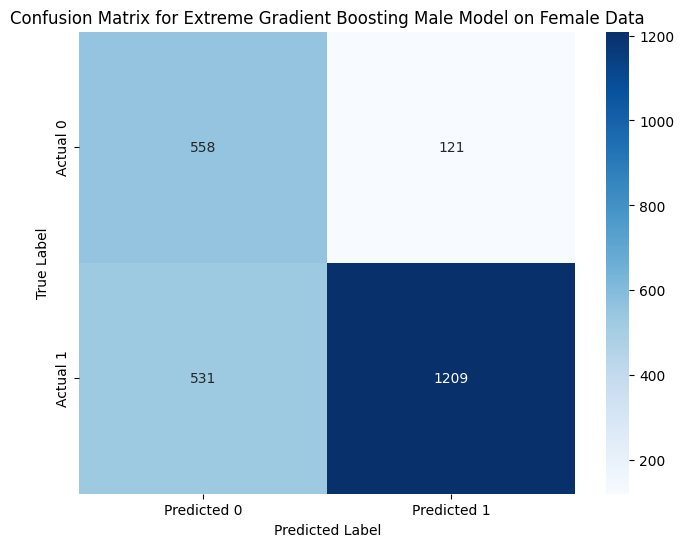

In [73]:
'''Test the male XGB model on the female dataset
'''

# load the female dataset
female_combined_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_female_df.csv")

# load a xgb male model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/male_models/99.17_xgb_male_model.json')


# rename 'label' to 'LABEL' if needed
if 'label' in female_combined_df.columns and 'LABEL' not in female_combined_df.columns:
    female_combined_df.rename(columns={'label': 'LABEL'}, inplace=True)

# separate label and features
X_test = female_combined_df.drop(columns=['LABEL'])  # replace 'target_column' if needed
y_test = female_combined_df['LABEL']  # if you have true labels for evaluation

# 2. Convert to DMatrix
dtest = xgb.DMatrix(X_test)

# 3. Make predictions
predictions = model.predict(dtest)

# If you have true labels, you can evaluate:
if 'y_test' in locals():
    from sklearn.metrics import accuracy_score, classification_report

    # For classification (if your model is classifier)
    predicted_classes = [round(value) for value in predictions]  # for binary classification
    accuracy = accuracy_score(y_test, predicted_classes)
    print(f"Accuracy: {accuracy:.2f}")

# create confusion matrix and plot
cm = confusion_matrix(y_test, predicted_classes)
plot_confusion_matrix(y_test, predicted_classes)
plt.title('Confusion Matrix for Extreme Gradient Boosting Male Model on Female Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

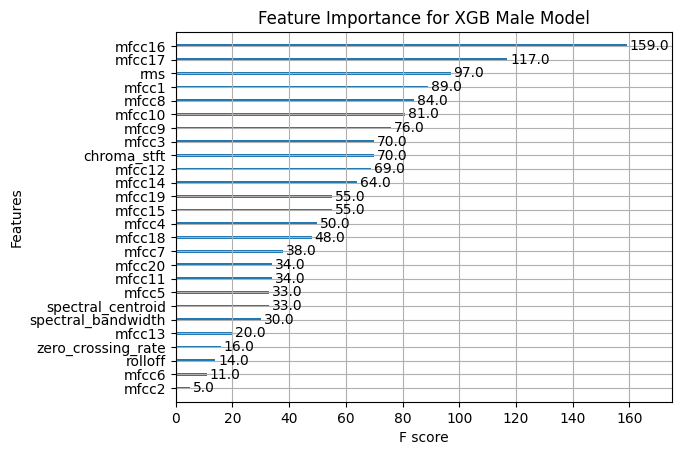

In [60]:
'''Feature Importance for XGB male model
'''
# load a xgb male model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/male_models/99.17_xgb_male_model.json')

# Feature importance plot
xgb.plot_importance(model)
plt.title('Feature Importance for XGB Male Model')
plt.show()

# Extreme Gradient Boosting Female Model Analysis

In [64]:
'''Classification report on XGB female model's own test data
'''

# load a xgb male model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/female_models/99.38_xgb_female_model.json')

# Make predictions
y_pred_proba = model.predict(dtest)  # Probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Class predictions

# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.9938

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       136
           1       0.99      1.00      1.00       348

    accuracy                           0.99       484
   macro avg       0.99      0.99      0.99       484
weighted avg       0.99      0.99      0.99       484



Accuracy: 0.60


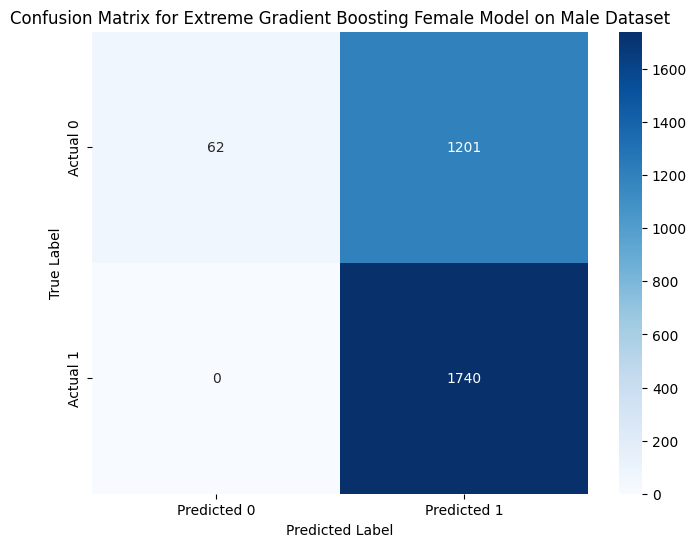

In [74]:
'''Test the female XGB model on the male dataset
'''

# load the female dataset
male_combined_df = pd.read_csv("/content/drive/My Drive/LING_199/combined_male_df.csv")

# load a xgb male model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/female_models/99.38_xgb_female_model.json')


# rename 'label' to 'LABEL' if needed
if 'label' in male_combined_df.columns and 'LABEL' not in male_combined_df.columns:
    male_combined_df.rename(columns={'label': 'LABEL'}, inplace=True)

# separate label and features
X_test = male_combined_df.drop(columns=['LABEL'])  # replace 'target_column' if needed
y_test = male_combined_df['LABEL']  # if you have true labels for evaluation

# 2. Convert to DMatrix
dtest = xgb.DMatrix(X_test)

# 3. Make predictions
predictions = model.predict(dtest)

# If you have true labels, you can evaluate:
if 'y_test' in locals():
    from sklearn.metrics import accuracy_score, classification_report

    # For classification (if your model is classifier)
    predicted_classes = [round(value) for value in predictions]  # for binary classification
    accuracy = accuracy_score(y_test, predicted_classes)
    print(f"Accuracy: {accuracy:.2f}")

# create confusion matrix and plot
cm = confusion_matrix(y_test, predicted_classes)
plot_confusion_matrix(y_test, predicted_classes)
plt.title('Confusion Matrix for Extreme Gradient Boosting Female Model on Male Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

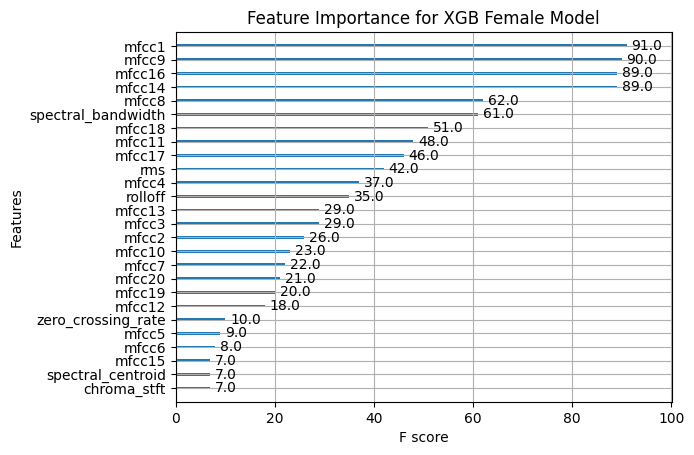

In [68]:
'''Feature Importance for XGB female model
'''
# load xgb female model
model = xgb.Booster()
model.load_model('/content/drive/My Drive/LING_199/trained_models/female_models/99.38_xgb_female_model.json')

# Feature importance plot
xgb.plot_importance(model)
plt.title('Feature Importance for XGB Female Model')
plt.show()

In [ ]:
# analysis of the best model
# 98.26 model has highest of 0.9876910016977929 at state 746
# split the data differently and test the model

# load a model
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False)

# PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure shape compatibility

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# list of accuracies
acc_list = []

# loop for 1000 different random splits
for i in range(0, 1000):

  # Split into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, stratify=y, random_state=i
  )

  # Create dataset objects
  train_dataset = CustomDataset(X_train, y_train)
  test_dataset = CustomDataset(X_test, y_test)

  # Training parameters
  num_epochs = 10
  batch_size = 32
  learning_rate = 0.001

  # Evaluation on the test set
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          predicted = (outputs > 0.5).float()
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

  acc_list.append(correct / total)

# print descriptive statistics of accuracies
print(f"Max Accuracy: {max(acc_list)}, Random State: {acc_list.index(max(acc_list))}")
print(f"Average Accuracy: {sum(acc_list)/len(acc_list):.4f}")
print(f"Min Accuracy: {min(acc_list)}")

Max Accuracy: 0.9872665534804754, Random State: 159
Average Accuracy: 0.9801
Min Accuracy: 0.9715619694397284


In [ ]:
# test on a new generated dataframe 0 is real, 1 is fake

# load the best model
model = torch.load('/content/drive/My Drive/LING_199/trained_models/full_models/98.34_model.pth', weights_only=False)

# get the extracted features dataframe from way at the beginning
linus_real_df_no_label = linus_real_df.drop(columns=['label'])

# convert this dataframe to a tensor
linus_real_tensor = torch.tensor(linus_real_df_no_label.values, dtype=torch.float32)

# run this data through the model
with torch.no_grad():
    outputs = model(linus_real_tensor.to('cuda'))
    predicted = (outputs > 0.5).float()

# there are 60 rows, one for each second of audio

# the outputs tensor is the probability that each row is fake
# print(outputs.mean())

# predicted object is the tensor where it rounds to 0 or 1 based on if it is above or below 0.5
# for example, one of the values in output is 0.56, that means the model predicted that that row is fake
# thus, predicted object would have that entry at 1
print(predicted.mean())